# Gerador de Músicas MIDI

O projeto consiste em realizar um estudo no qual serão geradas músicas sem intervenção humana. Para tal, utilizou-se de músicas clássicas de Chopin como dataset e um modelo de Deep Learning.

## Deep Learning - Uma breve introdução

O Deep Learning é um algoritmo de Machine Learning, no qual são utilizadas redes neurais que buscam "aprender" de forma similar ao comportamento humano.

Uma forma simples de entender é imaginar uma criança aprendendo a reconhecer objetos. A criança pode apontar para um objeto e dizer que é um carro. Dado isto, o pai/a mãe da criança pode reagir de duas maneiras: confirmar que o objeto que a criança apontou é um carro, ou falar "Não, isto é um jarro". Ao receber feedback suficiente, a criança começa a internalizar as características de cada objeto e cria um modelo mental que ajuda ela a reconhecer os diferentes objetos. Este modelo depende de uma comunicação efetiva entre os neurônios, transmitindo diferentes sinais e gerando este modelo complexo e hierárquico baseado no feedback recebido.

O Deep Learning busca replicar este comportamento, criando um modelo no qual não é necessário entender cada etapa e decisão feita devido à complexidade e profundidade deste. Para criar o modelo, são utilizadas múltiplas camadas de "neurônios digitais", que vão repassando o aprendizado de camada em camada.

Inicialmente, o modelo é alimentado com os dados a serem utilizados, e este tenta prever os dados, sem nenhuma intervenção. As previsões iniciais irão ser completamente (ou em sua maior parte) incorretas, mas conforme o modelo recebe feedback de suas previões, ele ajusta a comunicação entre seus "neurônios" até ser capaz de gerar previsões mais acuradas.

Existem diversos modelos de Deep Learning, e para o desenvolvimentod este projeto, irá ser utilizado o modelo de WaveNet.

## WaveNet

O WaveNet é um modelo de Deep Learning para áudios "crus" desenvolvido pelo Google DeepMind. Ele é chamado de "generative model", pois tem como objetivo gerar novos samples a partir da distribuição original dos dados. Ele atua de forma similar aos modelos de linguagem utilizados em NLP.

### Treinando o WaveNet

Para treinar o modelo de WaveNet, utiliza-se um trecho de uma onda crua de áudio (no caso, a onda de áudio no domínio do tempo) como input. Uma onda de áudio no domínio do tempo é representada na forma de diferente valores de amplitude em diferentes intervalos de tempo, como é possível visualizar no gif abaixo.

![Onda de áudio no domínio do tempo](https://jvbalen.github.io/figs/wavenet.gif)

A partir da sequência de valores de amplitude, o WaveNet tenta prever qual valor de amplitude vem em seguida.

In [19]:
# System libraries
from pathlib import Path
from collections import Counter

# Numpy for arrays and matplotlib for notes histogram
import numpy as np
import matplotlib.pyplot as plt

# Music21 library for MIDI reading and creating
import music21 as m21
from music21.note import Note
from music21.chord import Chord

# sklearn and keras for train/test of the model
from sklearn.model_selection import train_test_split
import keras.backend as kb
import keras.callbacks as kc
import keras.layers as kl
import keras.models as km

In [21]:
def read_midi(file):   
    notes = []
    
    # Parsing the MIDI file
    midi = m21.converter.parse(file)
  
    # Partition by instrument
    partition = m21.instrument.partitionByInstrument(midi)

    # Looping over all the instruments
    for part in partition.parts:
        # Select only the piano
        if 'Piano' not in str(part):
            continue

        # Checking if it is a note or a chord
        for element in part.recurse():
            if isinstance(element, Note):
                notes.append(str(element.pitch))

            elif isinstance(element, Chord):
                notes.append('.'.join(map(str, element.normalOrder)))

    return np.array(notes)

path = "./chopin/"
files = [p for p in Path(path).rglob("*") if p.is_file() and p.suffix == ".mid"]

notes_list = list(map(read_midi, files))

In [28]:
# Flattening notes_list
notes_f = np.concatenate(notes_list).ravel()

Number of unique notes: 397


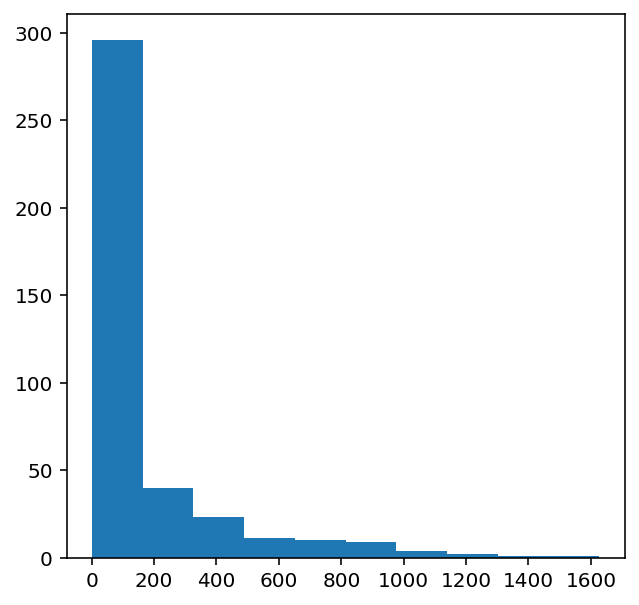

In [34]:
#computing frequency of each note
unique_notes, counts = np.unique(notes_f, return_counts=True)

# No. of unique notes
print(f"Number of unique notes: {len(unique_notes)}")

# Plot histogram
plt.figure(figsize=(5,5))
plt.hist(counts);

In [45]:
# Getting the most frequent notes
frequent_notes = frozenset(unique_notes[counts >= 40])

In [52]:
new_music = []

# Adding the most frequent notes
for notes in notes_list:
    new_music.append([note_ for note_ in notes if note_ in frequent_notes])

In [59]:
n_timesteps = 32
x = []
y = []

# TODO: fix CDE

for note_ in new_music:
    for i in range(len(note_) - n_timesteps):
        x.append(note_[i : i + n_timesteps])    # Input
        y.append(note_[i + n_timesteps])        # Output
        
x = np.array(x)
y = np.array(y)

In [60]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

# preparing input sequences
x_seq = []

for i in x:
    temp = []
    for j in i:
        # assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [61]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq = np.array([y_note_to_int[i] for i in y])

In [62]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq, y_seq, test_size=0.3, random_state=42)

In [63]:
kb.clear_session()
model = km.Sequential()
    
# embedding layer
model.add(kl.Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(kl.Conv1D(64,3, padding='causal',activation='relu'))
model.add(kl.Dropout(0.2))
model.add(kl.MaxPool1D(2))
    
model.add(kl.Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(kl.Dropout(0.2))
model.add(kl.MaxPool1D(2))

model.add(kl.Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(kl.Dropout(0.2))
model.add(kl.MaxPool1D(2))
          
model.add(kl.GlobalMaxPool1D())
    
model.add(kl.Dense(256, activation='relu'))
model.add(kl.Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           16900     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [64]:
mc = kc.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/50
298/298 [==============================] - ETA: 0s - loss: 4.5279
Epoch 00001: val_loss improved from inf to 4.35146, saving model to best_model.h5
298/298 [==============================] - 32s 107ms/step - loss: 4.5279 - val_loss: 4.3515
Epoch 2/50
298/298 [==============================] - ETA: 0s - loss: 4.0794
Epoch 00002: val_loss improved from 4.35146 to 4.08812, saving model to best_model.h5
298/298 [==============================] - 31s 105ms/step - loss: 4.0794 - val_loss: 4.0881
Epoch 3/50
298/298 [==============================] - ETA: 0s - loss: 3.8891
Epoch 00003: val_loss improved from 4.08812 to 3.98746, saving model to best_model.h5
298/298 [==============================] - 32s 108ms/step - loss: 3.8891 - val_loss: 3.9875
Epoch 4/50
298/298 [==============================] - ETA: 0s - loss: 3.7597
Epoch 00004: val_loss improved from 3.98746 to 3.91190, saving model to best_model.h5
298/298 [==============================] - 32s 107ms/step - loss: 3.7597 - v

Epoch 34/50
298/298 [==============================] - ETA: 0s - loss: 2.6472
Epoch 00034: val_loss did not improve from 3.19315
298/298 [==============================] - 24s 79ms/step - loss: 2.6472 - val_loss: 3.1994
Epoch 35/50
297/298 [============================>.] - ETA: 0s - loss: 2.6338
Epoch 00035: val_loss improved from 3.19315 to 3.18570, saving model to best_model.h5
298/298 [==============================] - 25s 85ms/step - loss: 2.6337 - val_loss: 3.1857
Epoch 36/50
298/298 [==============================] - ETA: 0s - loss: 2.6129
Epoch 00036: val_loss did not improve from 3.18570
298/298 [==============================] - 25s 85ms/step - loss: 2.6129 - val_loss: 3.1871
Epoch 37/50
297/298 [============================>.] - ETA: 0s - loss: 2.6086
Epoch 00037: val_loss improved from 3.18570 to 3.17766, saving model to best_model.h5
298/298 [==============================] - 23s 78ms/step - loss: 2.6091 - val_loss: 3.1777
Epoch 38/50
298/298 [=============================

In [65]:
idx = np.random.randint(0, len(x_val) - 1)

random_music = x_val[idx]
predictions = []

for i in range(10):
    random_music = random_music.reshape(1, n_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred = np.argmax(prob, axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
    random_music = random_music[1:]
    
print(predictions)

[62, 120, 86, 86, 62, 125, 67, 6, 67, 86]


In [66]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [67]:
# Deleting previously generated MIDI file
midi_file = "music.mid"
Path(midi_file).unlink(missing_ok=True)

In [68]:
def convert_to_midi(prediction_output, mf):
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for offset, pattern in enumerate(prediction_output):
        # pattern is a chord
        if '.' in pattern or pattern.isdigit():
            notes = []
            
            for current_note in pattern.split('.'):
                new_note = Note(int(current_note))
                new_note.storedInstrument = m21.instrument.Piano()
                notes.append(new_note)
                
            new_chord = Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            new_note = Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = m21.instrument.Piano()
            output_notes.append(new_note)
            
    midi_stream = m21.stream.Stream(output_notes)
    midi_stream.write('midi', fp=mf)

In [69]:
# Creating MIDI file
convert_to_midi(predicted_notes, midi_file)

# Shows MIDI in player
mf = m21.midi.MidiFile()
mf.open(midi_file)
mf.read()
mf.close()
s = m21.midi.translate.midiFileToStream(mf)
s.show('midi')